# Random trading strategy example

This dummy example demonstrates how to backtest a simple random trading strategy
using synthetic data generated in the script.
The price series is a random walk with a drift of 0.1 and initial price 1000.

The strategy randomly buys or sells an instrument with a probability of 1%.
Buy and sell orders use the same price series, implying a spread of 0.
Each trade is executed at a commission of 0.1%.
For the sake of illustration, only 75% of the order quantity is filled.

The account equity and drawdowns are collected for every hour
and plotted at the end using the Plots package.

In [1]:
using Fastback
using Dates
using Random

# set RNG seed for reproducibility
Random.seed!(42);

# generate synthetic price series
N = 2_000;
prices = 1000.0 .+ cumsum(randn(N) .+ 0.1);
dts = map(x -> DateTime(2020, 1, 1) + Hour(x), 0:N-1);

# create trading account with $10'000 start capital
acc = Account();
add_cash!(acc, Cash(:USD), 10_000.0);

# register a dummy instrument
DUMMY = register_instrument!(acc, Instrument(Symbol("DUMMY/USD"), :DUMMY, :USD))

# data collector for account equity and drawdowns (sampling every hour)
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));

# loop over price series
for (dt, price) in zip(dts, prices)
    # randomly trade with 1% probability
    if rand() < 0.01
        quantity = rand() > 0.4 ? 1.0 : -1.0
        order = Order(oid!(acc), DUMMY, dt, price, quantity)
        fill_order!(acc, order, dt, price; fill_qty=0.75order.quantity, commission_pct=0.001)
    end

    # update position and account P&L
    update_pnl!(acc, DUMMY, price)

    # collect data for plotting
    if should_collect(equity_data, dt)
        equity_value = equity(acc, :USD)
        collect_equity(dt, equity_value)
        collect_drawdown(dt, equity_value)
    end
end

# print account summary
show(acc)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ ACCOUNT SUMMARY ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cash balances (1)
┌─────┬──────────┐
│     │    Value │
├─────┼──────────┤
│ USD │ 10140.65 │
└─────┴──────────┘

Equity balances (1)
┌─────┬──────────┐
│     │    Value │
├─────┼──────────┤
│ USD │ 10260.77 │
└─────┴──────────┘

Positions (1)
┌───────────┬──────────┬────────────┬─────┬────────┐
│    Symbol │ Quantity │ Avg. price │ Ccy │    P&L │
├───────────┼──────────┼────────────┼─────┼────────┤
│ DUMMY/USD │     3.25 │    1086.99 │ USD │ 120.11 │
└───────────┴──────────┴────────────┴─────┴────────┘

Trades (23)
┌────┬───────────┬─────────────────────┬──────────┬──────────┬─────────────┬────────────┬─────┬──────────────┬───────┐
│ ID │    Symbol │                Date │ Quantity │ Fill qty │ Remain. qty │ Fill price │ Ccy │ Realized P&L │ Comm. │
├────┼───────────┼─────────────────────┼──────────┼──────────┼─────────────┼────────────┼─────┼──────────────┼───────┤
│  1 │ DUMMY/USD │ 2020-01-01 03:00:00 │ 

### Plot account equity curve

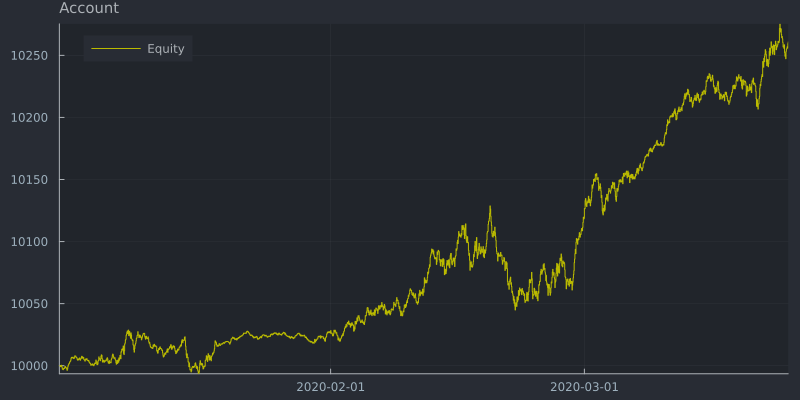

In [2]:
using Plots, Printf
theme(:juno; titlelocation=:left, titlefontsize=10, widen=false, fg_legend=:false)

# plot equity curve
p = plot(dates(equity_data), values(equity_data);
    title="Account",
    label="Equity",
    linetype=:steppost,
    yformatter=:plain,
    size=(800, 400),
    color="#BBBB00");
p

### Plot account equity drawdown curve

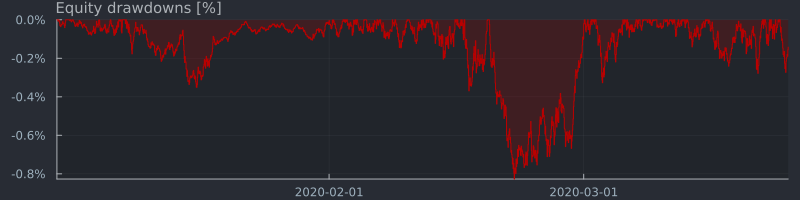

In [3]:
# plot drawdown curve
p = plot(dates(drawdown_data), 100values(drawdown_data);
    title="Equity drawdowns [%]",
    legend=false,
    linetype=:steppost,
    color="#BB0000",
    yformatter=y -> @sprintf("%.1f%%", y),
    size=(800, 200),
    fill=(0, "#BB000033"));
p